## Welcome to our Random Forests workshop!

In the previous workshop, we learned a strong classification algorithm called `decision tree`. This week, we are going to improve on it and introduce a new model called `Random Forest`.

### Random Forests
Random forest is a supervised learning algorithm. The `forest` it builds is an ensemble of decision trees, usually trained with the bagging method. The general idea of the bagging method is that a combination of learning models increases the overall result.
One big advantage of random forest is that it can be used for both classification and regression problems, which form the majority of current machine learning systems.
### How does it work?
- Random forests simply combine multiple decision trees to imrpove model accuracy and reduce overfitting.
- It works by training each decision tree on a random subset of the data and features, and then aggregating their predictions.

Today, we are going to build our own random forest model from scratch and use it to do classification tasks on a dataset.

#### Wine Dataset
The dataset we will use today is called `Wine`. The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine. Let's explore this dataset.

First few rows of the Iris dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0       0  setosa  
1       0  setosa  
2       0  setosa  
3       0  setosa  
4       0  setosa  

Statistical summary of the dataset:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%    

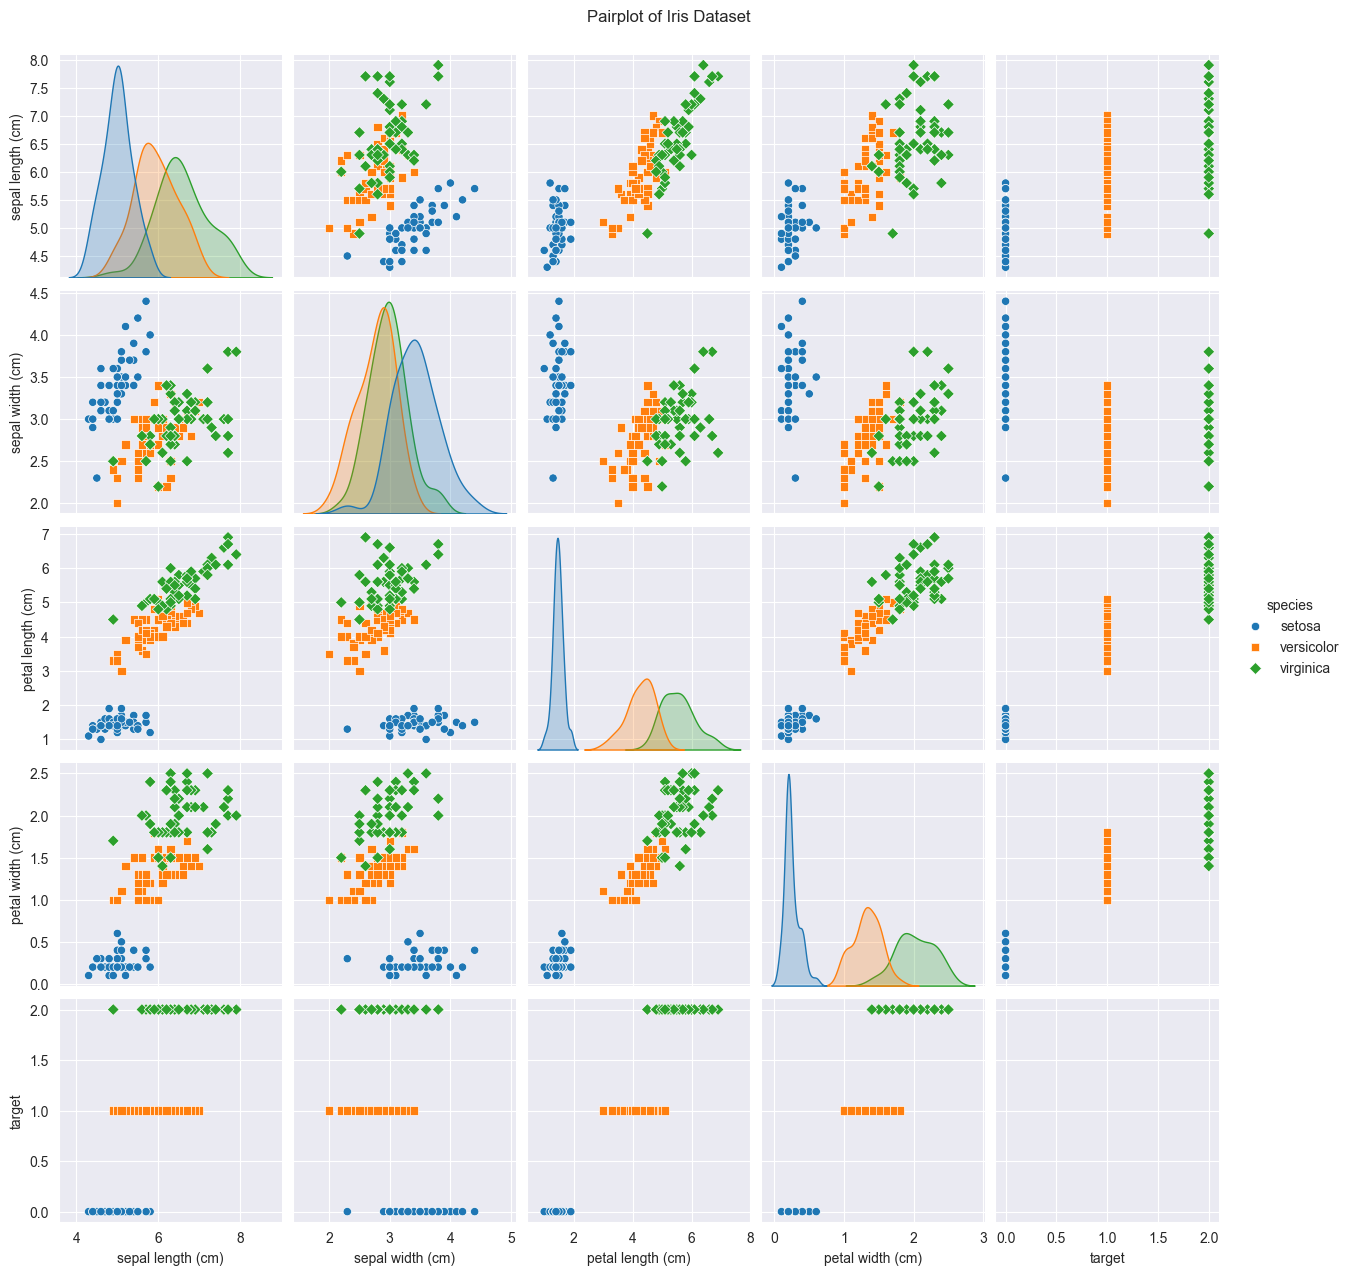

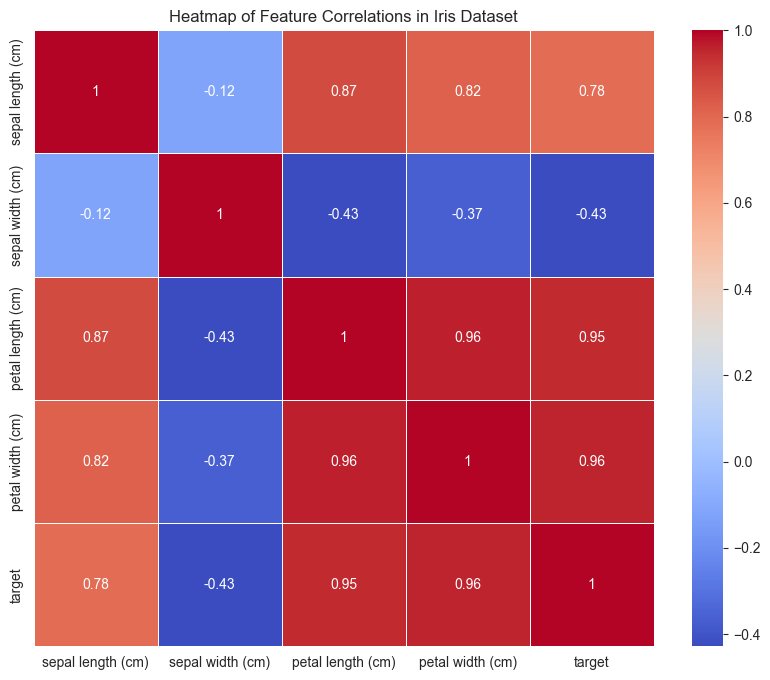

Accuracy: 1.00

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Cross-Validation Scores: [1.         0.96666667 0.86666667 0.93333333 0.73333333]
Mean Accuracy: 0.90
Standard Deviation: 0.09


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from decision_tree import DecisionTree
from scipy.stats import mode

In [2]:
# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
class_names = wine.target_names

# Convert to DataFrame for easier manipulation
wine_df = pd.DataFrame(X, columns=feature_names)
wine_df['target'] = y
wine_df['class'] = wine_df['target'].apply(lambda x: class_names[x])

# Display the first few rows of the dataset
print(wine_df.head())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target    class  
0 

In [3]:
# Descriptive statistics
print(wine_df.describe())

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

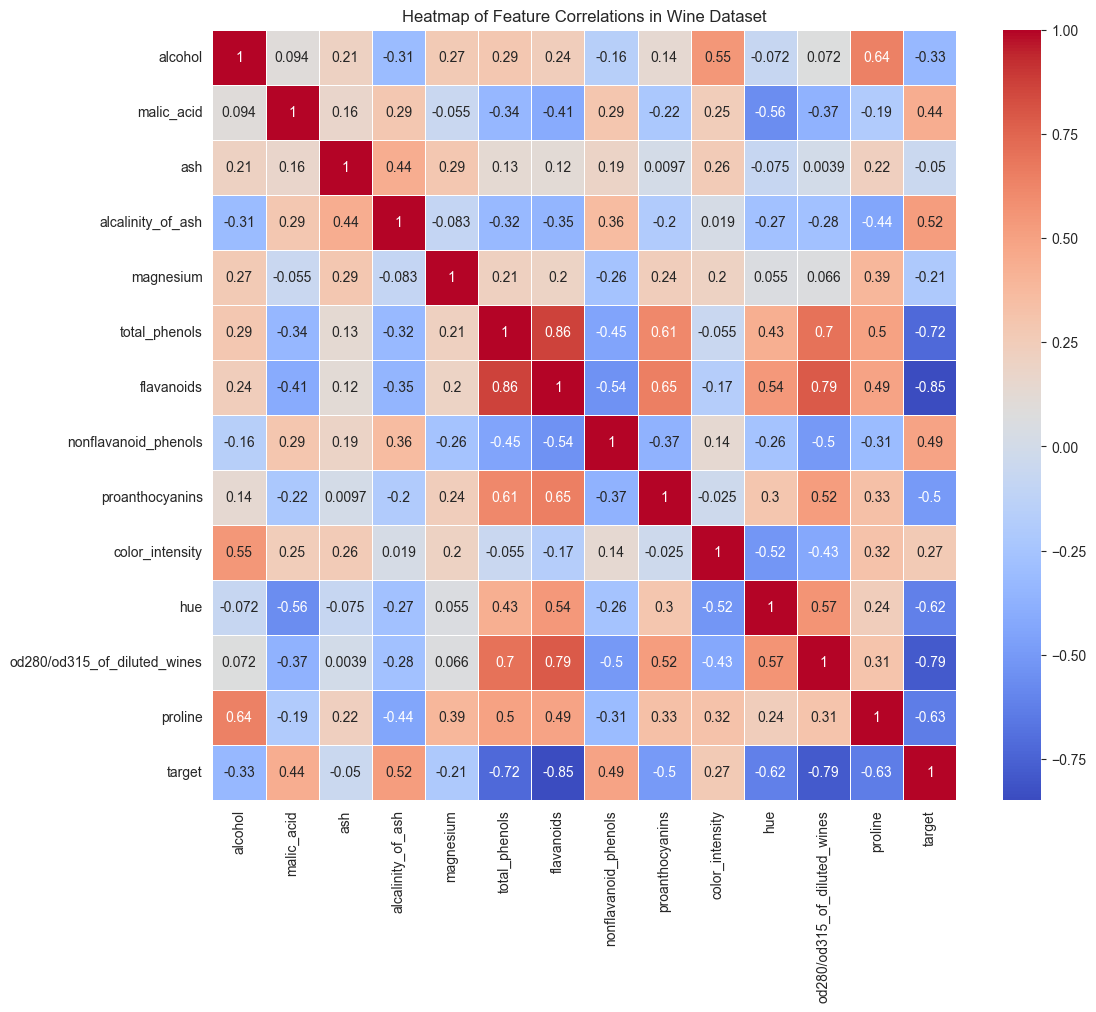

In [4]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
corr_matrix = wine_df.drop(columns=['class']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations in Wine Dataset')
plt.show()

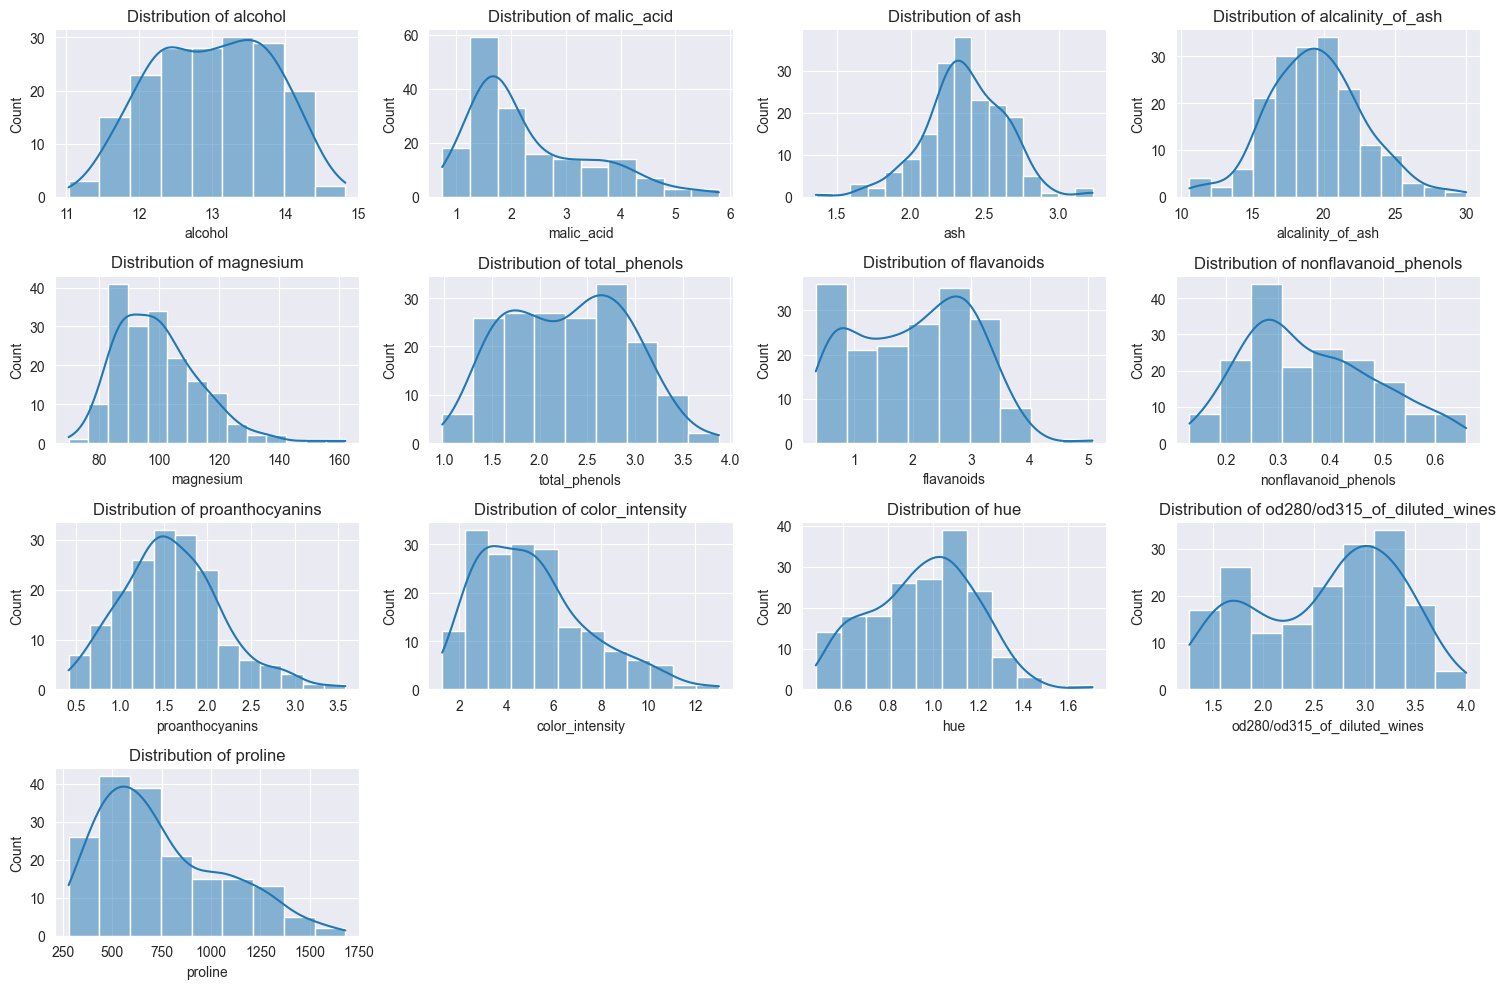

In [5]:
# Distribution of each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 4, i + 1)
    sns.histplot(wine_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

Now that we analyzed the dataset, we can start implementing our own Random Forest from scratch.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = [DecisionTree(max_depth=max_depth) for _ in range(n_estimators)]

    def fit(self, X, y):
        self.samples = []
        n_samples = X.shape[0]
        for tree in self.trees:
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            tree.fit(X[idxs], y[idxs])
            self.samples.append(idxs)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Calculate the mode of predictions
        return mode(tree_preds, axis=0)[0].flatten()

In [11]:
rf = RandomForest(n_estimators=10, max_depth=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [12]:
y_pred_rf

array([0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0], dtype=int64)

In [13]:
# Evaluate the RandomForest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"RandomForest Accuracy: {accuracy_rf:.2f}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)

class_report_rf = classification_report(y_test, y_pred_rf, target_names=class_names)
print("\nClassification Report:")
print(class_report_rf)

RandomForest Accuracy: 0.97

Confusion Matrix:
[[14  0  0]
 [ 0 14  0]
 [ 0  1  7]]

Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        14
     class_1       0.93      1.00      0.97        14
     class_2       1.00      0.88      0.93         8

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



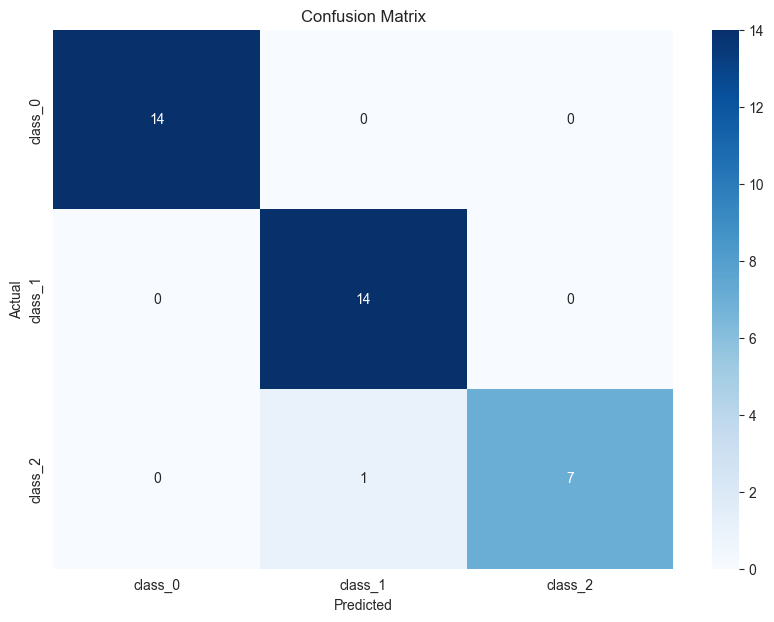

In [14]:
# Visualize the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()